In [3]:
import numpy as np
import os
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

# Function to produce training and targets using full dataset tables
def produceXYDataSets(ticker, corp, ns_back): 
    df = pd.read_csv('~/data/finance'+'/optionchaindata/all/'+ticker+'_alldata_'+corp+'.csv.zip', parse_dates=['quoteDate','expiryDate'])
    print("Dataframe shape from file",df.shape)
    
    #basic data cleaning, remove lines where the strike price is more than 50 from the stockprice
    df_good = df[ df['strikeDelta'] > -50 ]
    print("After removing deltastrike bigger than -50", df_good.shape)

    df_good = df_good[ df_good['strikeDelta'] < 50 ]
    print("After removing deltastrike less than 50", df_good.shape)

    #All contract names to read through
    contracts = df_good['contractSymbol'].unique()

    x_train = []
    y_train = []

    #Only look at contracts that have at least 1.5 time as many entries as the look back time
    nquotes_min = int(1.5*ns_back)
    good_contracts = []

    for contract in contracts:
        data = df_good[df_good['contractSymbol'] == contract]
        
        if data.shape[0] < nquotes_min:
            continue
        
        good_contracts.append(contract)
        
        data['deltaDays'] = data['quoteDate'].diff()
        data['weekday'] = data['quoteDate'].dt.dayofweek

        ndays = data.shape[0]

        for iday in range(ns_back+1, ndays):
            #X:
            stockPrices = data['stockClose'][iday-ns_back:iday].values
            strike = data['strike'].values[iday]
            openInterest = data['openInterest'].values[iday]
            daysToExpiry = int(data['daysToExpiry'].values[iday].split('days')[0])
            deltaDays = data['deltaDays'].values[iday]/ np.timedelta64(1, 'D')
            weekday = data['weekday'].values[iday]

            features =np.concatenate( [[strike, openInterest, daysToExpiry, deltaDays, weekday], stockPrices] )

            #y:
            ask = data['ask'].values[iday]
            bid = data['bid'].values[iday]

            targets = np.array([bid, ask])

            #print(weekday,ask,bid,daysToExpiry,deltaDays, strike,stock_prices)
            x_train.append(features)
            y_train.append(targets)
    

    x_train = np.array(x_train)
    y_train = np.array(y_train)
    
    print("Used",len(good_contracts),"contracts total")
    print("Done, made data set with",x_train.shape[0],"samples")
    
    xydata = np.concatenate([x_train,y_train], axis=1)
    DATA_PATH = os.path.expanduser('~/data/')  # Expands the ~ to the full home directory path
    directory = os.path.join(DATA_PATH, 'save/')

    if not os.path.exists(directory):
        os.makedirs(directory)
        
    np.save(directory+ticker+'_'+corp+'_XY.npy',xydata)
    
    return x_train, y_train
   




In [4]:
# Initialize lists to collect the training data
x_train_all = []
y_train_all = []

# List of NASDAQ tickers that are also in the dataset
tickers = ['AAPL']
#tickers = [
#    'AAPL', 'META', 'NFLX', 'SHOP', 'NVDA', 'AMD', 'GOOGL',
#    'AMZN', 'INTC', 'FB', 'MSFT', 'PYPL', 'TSLA'
#]

# Loop over each ticker symbol
for ticker in tickers:
    try:
        x_train_ticker, y_train_ticker = produceXYDataSets(ticker, "C", 20)
        x_train_all.append(x_train_ticker)
        y_train_all.append(y_train_ticker)
    except Exception as e:
        print(f"Failed to process ticker {ticker}: {e}")

# Concatenate the lists into numpy arrays
x_train_all = np.concatenate(x_train_all, axis=0)
y_train_all = np.concatenate(y_train_all, axis=0)

# Split the data into training and testing sets
x_train_all, x_test, y_train_all, y_test = train_test_split(x_train_all, y_train_all, test_size=0.2, random_state=42)


# Scale the data
scaler_x = preprocessing.MinMaxScaler()
scaler_y = preprocessing.MinMaxScaler()

x_train_all_scaled = scaler_x.fit_transform(x_train_all)
y_train_all_scaled = scaler_y.fit_transform(y_train_all)

x_test_scaled = scaler_x.transform(x_test)
y_test_scaled = scaler_y.transform(y_test)




Dataframe shape from file (187867, 30)
After removing deltastrike bigger than -50 (132526, 30)
After removing deltastrike less than 50 (94202, 30)


/tmp/ipykernel_2877490/2180113838.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['deltaDays'] = data['quoteDate'].diff()
/tmp/ipykernel_2877490/2180113838.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['weekday'] = data['quoteDate'].dt.dayofweek
/tmp/ipykernel_2877490/2180113838.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

Used 814 contracts total
Done, made data set with 48809 samples


In [5]:

# Define the RNN model with LSTM
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape, recurrent_dropout=0.1))
    model.add(LSTM(50, return_sequences=False, recurrent_dropout=0.1))
    model.add(Dropout(0.2))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(2, activation='linear'))  # Predicting two values: bid and ask prices
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Prepare the data for LSTM
if len(x_train_all_scaled.shape) == 2:
    x_train_all_scaled = np.expand_dims(x_train_all_scaled, axis=2)

if len(x_test_scaled.shape) == 2:
    x_test_scaled = np.expand_dims(x_test_scaled, axis=2)

# Build the model
model = build_lstm_model(input_shape=(x_train_all_scaled.shape[1], x_train_all_scaled.shape[2]))

# Train the model
history = model.fit(x_train_all_scaled, y_train_all_scaled, epochs=10, batch_size=64, validation_split=0.2)



2023-11-10 17:58:08.271862: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-11-10 17:58:08.271944: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: neutrino
2023-11-10 17:58:08.271959: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: neutrino
2023-11-10 17:58:08.272152: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 470.223.2
2023-11-10 17:58:08.272176: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 470.199.2
2023-11-10 17:58:08.272183: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:312] kernel version 470.199.2 does not match DSO version 470.223.2 -- cannot find working devices in this configuration


Epoch 1/10
489/489 [==============================] - 22s 37ms/step - loss: 0.0539 - val_loss: 0.0316
Epoch 2/10
489/489 [==============================] - 18s 36ms/step - loss: 0.0231 - val_loss: 0.0126
Epoch 3/10
489/489 [==============================] - 18s 36ms/step - loss: 0.0155 - val_loss: 0.0105
Epoch 4/10
489/489 [==============================] - 18s 36ms/step - loss: 0.0131 - val_loss: 0.0088
Epoch 5/10
489/489 [==============================] - 17s 36ms/step - loss: 0.0116 - val_loss: 0.0098
Epoch 6/10
489/489 [==============================] - 18s 36ms/step - loss: 0.0104 - val_loss: 0.0102
Epoch 7/10
489/489 [==============================] - 18s 36ms/step - loss: 0.0092 - val_loss: 0.0069
Epoch 8/10
489/489 [==============================] - 18s 36ms/step - loss: 0.0082 - val_loss: 0.0049
Epoch 9/10
489/489 [==============================] - 18s 36ms/step - loss: 0.0072 - val_loss: 0.0043
Epoch 10/10
489/489 [==============================] - 18s 36ms/step - loss: 0.006

In [17]:

# Evaluate the model on the test set
test_loss = model.evaluate(x_test_scaled, y_test_scaled)
print(f"Test loss: {test_loss}")

# Make predictions on the test set
predictions = model.predict(x_test_scaled)

# Inverse transform the scaled predictions to original scale
predictions_original = scaler_y.inverse_transform(predictions)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Save the trained model
model.save('combined_model.h5')

print("Model training complete and saved. Model evaluated on test data.")

print(predictions_original)

306/306 [==============================] - 2s 7ms/step - loss: 0.0038
Test loss: 0.0038460162468254566
306/306 [==============================] - 2s 7ms/step
Model training complete and saved. Model evaluated on test data.
[[19.540403  20.503305 ]
 [28.331808  29.212585 ]
 [24.556618  25.622976 ]
 ...
 [ 1.6132675  1.5171776]
 [47.004612  48.660995 ]
 [ 1.8583279  2.1761756]]


/home/npacey/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Mean Squared Error: 16.460878231276663
Mean Absolute Error: 3.118479687861641


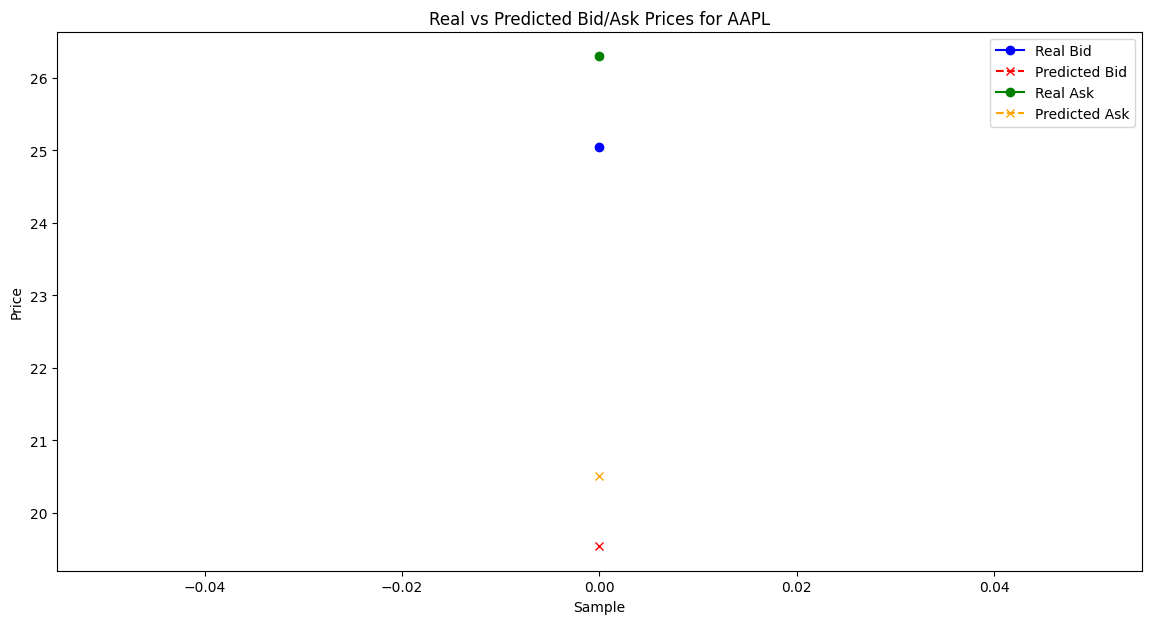

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Function to calculate and print error metrics
def evaluate_predictions(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")

# Evaluate predictions
evaluate_predictions(y_test_original, predictions_original)

# Plotting the real vs predicted values
def plot_predictions(y_true, y_pred, ticker):
    plt.figure(figsize=(14, 7))
    plt.plot(y_true[:, 0], label='Real Bid', color='blue', marker='o')
    plt.plot(y_pred[:, 0], label='Predicted Bid', color='red', linestyle='--', marker='x')
    plt.plot(y_true[:, 1], label='Real Ask', color='green', marker='o')
    plt.plot(y_pred[:, 1], label='Predicted Ask', color='orange', linestyle='--', marker='x')
    plt.title(f'Real vs Predicted Bid/Ask Prices for {ticker}')
    plt.xlabel('Sample')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Assuming you have a way to map back the test samples to their corresponding tickers
# For example, if you have a list `tickers` that maps each sample in `x_test` to its ticker
tickers = tickers
# You would need to create this mapping before splitting the data into training and testing sets

# Plot the real vs predicted values for each ticker
unique_tickers = np.unique(tickers)
for ticker in unique_tickers:
    ticker_indices = [i for i, t in enumerate(tickers) if t == ticker]
    plot_predictions(y_test_original[ticker_indices], predictions_original[ticker_indices], ticker)


Mean Squared Error: 16.460878231276663
Mean Absolute Error: 3.118479687861641


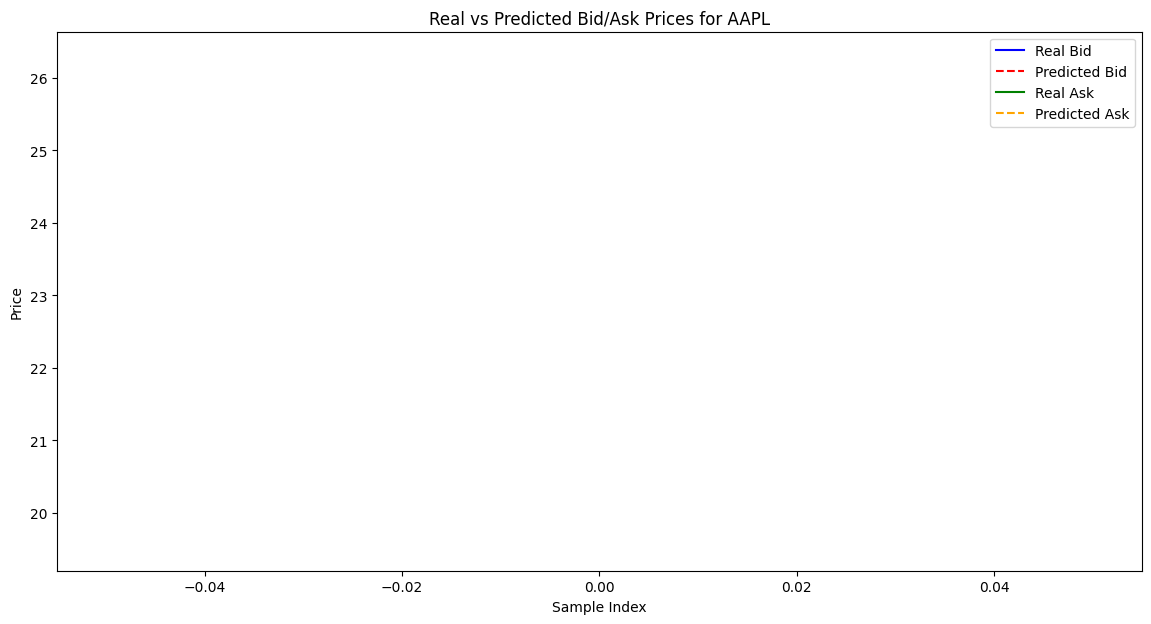

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Function to calculate and print error metrics
def evaluate_predictions(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")

# Evaluate predictions
evaluate_predictions(y_test_original, predictions_original)

# Plotting the real vs predicted values for all samples
def plot_predictions(y_true, y_pred, ticker):
    plt.figure(figsize=(14, 7))
    plt.plot(y_true[:, 0], label='Real Bid', color='blue')
    plt.plot(y_pred[:, 0], label='Predicted Bid', color='red', linestyle='--')
    plt.plot(y_true[:, 1], label='Real Ask', color='green')
    plt.plot(y_pred[:, 1], label='Predicted Ask', color='orange', linestyle='--')
    plt.title(f'Real vs Predicted Bid/Ask Prices for {ticker}')
    plt.xlabel('Sample Index')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Assuming you have a way to map back the test samples to their corresponding tickers
# For example, if you have a list `tickers` that maps each sample in `x_test` to its ticker
# You would need to create this mapping before splitting the data into training and testing sets

# Plot the real vs predicted values for each ticker
for ticker in tickers:
    ticker_indices = [i for i, t in enumerate(tickers) if t == ticker]
    plot_predictions(y_test_original[ticker_indices], predictions_original[ticker_indices], ticker)


Plotting data for option: AAPL
y_true_option: [[100 102]]
y_pred_option: [[ 99 101]]


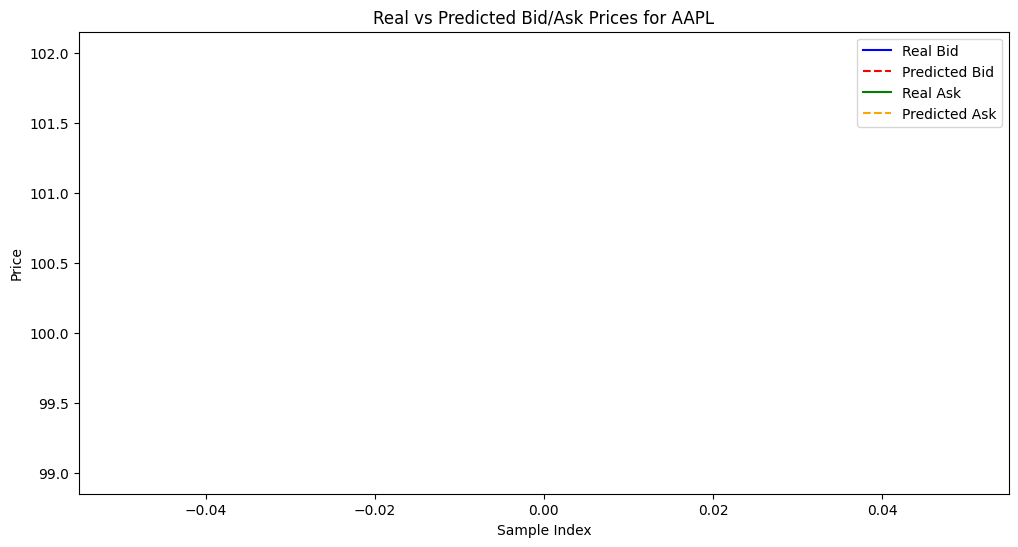

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_option_predictions(y_true, y_pred, option_names):
    unique_options = set(option_names)

    for option in unique_options:
        indices = [i for i, name in enumerate(option_names) if name == option]
        if not indices:
            print(f"No data found for option: {option}")
            continue

        y_true_option = y_true[indices]
        y_pred_option = y_pred[indices]

        if y_true_option.size == 0 or y_pred_option.size == 0:
            print(f"No data to plot for option: {option}")
            continue

        print(f"Plotting data for option: {option}")
        print("y_true_option:", y_true_option)
        print("y_pred_option:", y_pred_option)

        plt.figure(figsize=(12, 6))
        plt.plot(y_true_option[:, 0], label='Real Bid', color='blue')
        plt.plot(y_pred_option[:, 0], label='Predicted Bid', color='red', linestyle='--')
        plt.plot(y_true_option[:, 1], label='Real Ask', color='green')
        plt.plot(y_pred_option[:, 1], label='Predicted Ask', color='orange', linestyle='--')
        plt.title(f'Real vs Predicted Bid/Ask Prices for {option}')
        plt.xlabel('Sample Index')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

# Test with example data
option_names = ['AAPL']
y_test_original = np.array([[100, 102], [101, 103]])  # Example data
predictions_original = np.array([[99, 101], [100, 102]])  # Example data

plot_option_predictions(y_test_original, predictions_original, option_names)
